**BÁO CÁO BÀI TẬP LỚN HỌC MÁY CUỐI KỲ**

**Mã Lớp**: INT3405_1

**Họ và tên**: Phạm Ngọc Dũng

**Mã số sinh viên**: 18020378

# Giới thiệu bài toán
Quora là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên Quora, mọi người có thể đặt câu hỏi và kết nối với những người khác, những người đóng góp thông tin chi tiết độc đáo và câu trả lời chất lượng.Vì là một nền tảng mở ai cũng có thể đọc và hỏi đáp một cách dễ dàng nên sẽ có những người đưa ra những định kiến, những câu hỏi mang tính độc hại chia rẽ.

Bài toán đặt ra là ta cần phân loại được đâu là những câu hỏi chân thành (Sincere) và không chân thành (Insincere).

input: câu hỏi dạng text

output: 1/0(không chân thành/ chân thành)

Import thư viện cần thiết

In [ ]:
#import thư viện
import os
import time
import numpy as np
import pandas as pd 
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalMaxPool1D, Dropout, Activation,CuDNNLSTM
from keras.layers import MaxPooling1D, BatchNormalization,Conv2D,Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D,CuDNNLSTM
from keras.layers import Dense, Input , LSTM , Embedding , Conv1D , Bidirectional , GRU , Dropout, CuDNNGRU
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Đọc dữ liệu

In [ ]:
train_df = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_df = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
train_df.info()
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Xem qua 1 vài ví dụ về dữ liệu tập train

In [ ]:
train_df.head()

xem qua 1 vài ví dụ tập test

In [ ]:
test_df.head()

dữ liệu gồm 3 cột thông tin:

qid: ID câu hỏi

question_text: nội dung câu hỏi-> cần được phân loại

target: kết quả của các câu hỏi:0/1(chân thành/ không chân thành)

dữ liệu tập train có 1306122 questions, tập test là 375806 questions

# Phân tích dữ liệu

In [ ]:
target = train_df['target']
target_1 = 0
for target_value in target:
    if target_value == 1:
        target_1 += 1
print("Số câu hỏi trong tệp train:", len(target))
print("Số câu hỏi được gán nhãn là 1:", target_1)
myLabels = ["insincere question", "sincere question"]
myCounts = [target_1, len(target) - target_1]
plt.pie(myCounts, labels = myLabels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

Đánh giá: dữ liệu có sự chênh lệch lớn giữa câu chân thành và không chân thành với tỉ lệ 1:15. VIệc này ảnh hưởng rất lớn đến độ chính xác của model. Vì vậy trong bài này em sử dụng f1 score để giúp cho sự chính xác của mô hình không bị ảnh hưởng

# F1_score
F1 score là trung bình điều hòa giữa precision và recall

Precision được định nghĩa là tỉ lệ số điểm Positive mô hình dự đoán đúng trên tổng số điểm mô hình dự đoán là Positive.Precision cầng cao tức là số điểm dự đoán positve càng đúng không bị nhầm lẫn

Recall được định nghĩa là tỉ lệ số điểm Positive mô hình dự đoán đúng trên tổng số điểm thật sự là Positive (hay tổng số điểm được gán nhãn là Positive ban đầu). Recall càng cao tức là số lượng điểm positive bị bỏ lở càng ít.

$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1 = \frac{2}{Recall^{-1} + Precision^{-1}}$$

Để đánh giá được 1 câu có chân thành hay không, thống kê những từ hay xuất hiện trong mỗi loại câu này từ đó biết được các mối liên hệ của chúng đối với câu
WordCloud là kỹ thuật trực quan hóa dữ liệu sử dụng để biểu dẫn văn bản. Trong đó kích thước của từ cho biết tần xuất xuất hiện và độ quan trọng của nó.


In [ ]:
from wordcloud import WordCloud, STOPWORDS
print('Ảnh word cloud được tạo từ những câu hỏi chân thành:')
sincere_wordcloud = WordCloud(width=600, height=400, background_color ='black', min_font_size = 10).generate(str(train_df[train_df['target'] == 0]["question_text"]))
#Positive Word cloud
plt.figure(figsize=(15,6), facecolor=None)
plt.imshow(sincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

In [ ]:
print('Ảnh word cloud được tạo từ những câu hỏi thiếu chân thành:')
insincere_wordcloud = WordCloud(width=600, height=400, background_color ='white', min_font_size = 10).generate(str(train_df[train_df['target'] == 1]["question_text"]))
#Positive Word cloud
plt.figure(figsize=(15,6), facecolor=None)
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

Nhận xét: 
Trong phần các câu thiếu chân thành ta thấy chúng chủ yếu tập trung các vấn đề là phân biệt màu da,quốc gia: black-white,united-indian nhân vật chính trị:trump, hay phân biệt 

# Tiền xử lí dữ liệu

Ta nhận thấy dữ liệu còn khá phức tạp và có cả những dữ liệu dư thừa. Chúng ta cần xử lí qua chúng bằng cách: 

loại bỏ các công thức toán học, đường dẫn

chuẩn hóa các từ viết tắt-> dạng đầy đủ

sửa lỗi chính tả 1 vài từ 

Xóa bỏ các kí tự đặc biệt

# Xóa ký tự đặc biệt
Về cơ bản những kí tự đặc biệt này không có ý nghĩa, tránh việc dư thừa ta thực hiện xóa bỏ chúng

In [ ]:
punctuation_list =[',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

In [ ]:
def remove_punctuation(text):
    for punctuation in punctuation_list:
        if punctuation in text:
            text = text.replace(punctuation, '{}' .format(punctuation))
    return text

# Xóa số

In [ ]:
def clean_numbers(text):
    if bool(re.search(r'\d', text)):
        text = re.sub('[0-9]{5,}', '#####', text)
        text = re.sub('[0-9]{4}', '####', text)
        text = re.sub('[0-9]{3}', '###', text)
        text = re.sub('[0-9]{2}', '##', text)
    return text

# Sửa lỗi chính tả
từ dữ liệu ta thấy trong đây có cả Anh-Anh và Anh-Mỹ. hay lỗi chính tả. Để embedding word có độ phủ cao ta cần sửa các lỗi nhỏ này đưa chúng về 1 chuẩn chung qua đó độ phủ vocab sẽ cao hơn

In [ ]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

In [ ]:
import re
def get_misspelled_dict_and_regex(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = get_misspelled_dict_and_regex(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

# Chuẩn hóa các từ viết tắt 

In [ ]:
contraction_dict = {
    "ain't": "is not", 
    "aren't": "are not",
    "can't": "cannot", 
    "'cause": "because", 
    "could've": "could have", 
    "couldn't": "could not", 
    "didn't": "did not",  
    "doesn't": "does not", 
    "don't": "do not", 
    "hadn't": "had not", 
    "hasn't": "has not", 
    "haven't": "have not", 
    "he'd": "he would",
    "he'll": "he will", 
    "he's": "he is", 
    "how'd": "how did", 
    "how'd'y": "how do you", 
    "how'll": "how will", 
    "how's": "how is",  
    "I'd": "I would", 
    "I'd've": "I would have",
    "I'll": "I will", 
    "I'll've": "I will have",
    "I'm": "I am", 
    "I've": "I have", 
    "i'd": "i would", 
    "i'd've": "i would have", 
    "i'll": "i will",  
    "i'll've": "i will have",
    "i'm": "i am", 
    "i've": "i have", 
    "isn't": "is not", 
    "it'd": "it would", 
    "it'd've": "it would have", 
    "it'll": "it will", 
    "it'll've": "it will have",
    "it's": "it is", 
    "let's": "let us", 
    "ma'am": "madam", 
    "mayn't": "may not", 
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have", 
    "must've": "must have", 
    "mustn't": "must not", 
    "mustn't've": "must not have", 
    "needn't": "need not", 
    "needn't've": "need not have",
    "o'clock": "of the clock", 
    "oughtn't": "ought not", 
    "oughtn't've": "ought not have", 
    "shan't": "shall not", 
    "sha'n't": "shall not", "shan't've": "shall not have", 
    "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", 
    "she's": "she is", "should've": "should have", 
    "shouldn't": "should not", "shouldn't've": "should not have", 
    "so've": "so have","so's": "so as", "this's": "this is",
    "that'd": "that would", "that'd've": "that would have", 
    "that's": "that is", "there'd": "there would", 
    "there'd've": "there would have", "there's": "there is", 
    "here's": "here is","they'd": "they would", "they'd've": "they would have", 
    "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", 
    "to've": "to have", "wasn't": "was not", 
    "we'd": "we would", "we'd've": "we would have", 
    "we'll": "we will", "we'll've": "we will have", 
    "we're": "we are", "we've": "we have", 
    "weren't": "were not", "what'll": "what will", 
    "what'll've": "what will have", "what're": "what are",  
    "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", 
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
    "will've": "will have", "won't": "will not", "won't've": "will not have", 
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
    "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
    "you're": "you are", "you've": "you have"}

In [ ]:
def get_contractions_dict_and_regex(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = get_contractions_dict_and_regex(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [ ]:
def clean_questions(x):
    x = x.lower()
    x = remove_punctuation(x)
    x = clean_numbers(x)
    x = replace_typical_misspell(x)
#     x = remove_stopwords(x)
    x = replace_contractions(x)
    x = x.replace("'","")
    return x

In [ ]:
train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_questions(x))
test_df['question_text'] = test_df['question_text'].apply(lambda x: clean_questions(x))

Sau khi clean question, điều chúng ta cần làm đó là vector hóa text để máy tính có thể hiểu và học được nghĩa của từ, ở đây ta có sẵn các tool embedding convert word thành matrix số thực. Các từ khi được nhúng vào chiều không gian vẫn sẽ giữ được quan hệ ngữ nghĩa giữa các từ với nhau

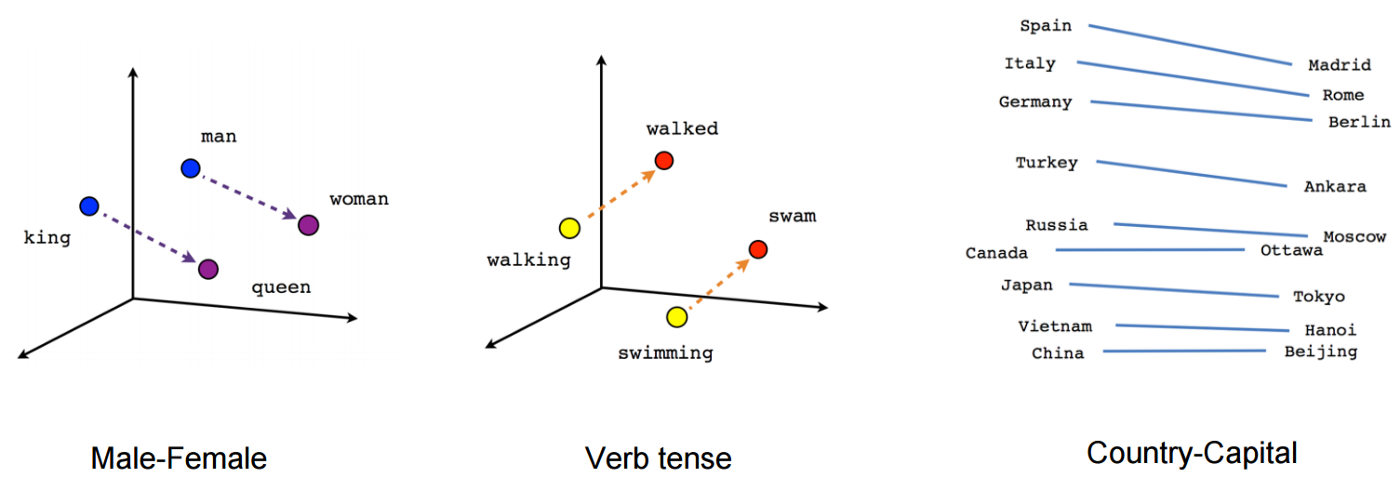


In [ ]:
from zipfile import ZipFile
file_name = "../input/quora-insincere-questions-classification/embeddings.zip"
with ZipFile(file_name, 'r') as zip:
     # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
glove_path = '../working/glove.840B.300d/glove.840B.300d.txt'
paragram_path =  '../working/paragram_300_sl999/paragram_300_sl999.txt'
wiki_news_path = '../working/wiki-news-300d-1M/wiki-news-300d-1M.vec'

tokenize: tách câu văn thành các token(từ) và gắn cho nó 1 id bằng cách thống kê số đánh số thứ tự theo tần suất xuất hiện. Bằng cách vector hóa này ta có thể mã hóa được tất cả các từ vựng tuy nhiên nhược điểm sẽ là số chiều vector rất lớn ảnh hưởng tới xử lí và lưu trữ
padding: tokenize chỉ giúp chúng ta mã hóa câu văn thành 1 matrix.Mà các câu văn có độ dài không đồng nhất, Để thuận tiện cho việc tính toán, huấn luyện mô hình người ta sẽ padding tất cả các chuỗi thành 100 từ ít hơn 100 thì họ thêm 0 còn nhiều hơn 100 thì đem cắt. Như vậy ta được vector 100 chiều 

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2021)
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)

test_X = pad_sequences(test_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
## Get the target values
train_y = train_df['target'].values
print("Done")

In [ ]:
train_y = train_df['target'].values
val_y = val_df['target'].values

Vai trò của file embedding: mã hóa các word thành 1 vecto để model xử lí được. Thay vì ta thống kê chúng thì từ những file embedding này nó đã được gg  thực hiện sẵn và mã hóa các từ thành các vector số qua đó giúp chúng ta giảm thời gian train và cải thiện được hiệu suất

In [ ]:
def load_glove(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(glove_path))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

def load_fasttext(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(wiki_news_path) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(paragram_path, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

Ta sử dụng cả 3 bộ embedding để tăng độ phủ của các từ trong file embedding giúp hiệu quả hơn

In [ ]:
glove_embedding = load_glove(tokenizer.word_index)
fasttext_embedding = load_fasttext(tokenizer.word_index)
para_embedding = load_para(tokenizer.word_index)
embedding_matrix = np.mean([glove_embedding, fasttext_embedding, para_embedding], axis = 0)

# Mô Hình

Đầu tiên xét về bài toán, đó là 1 bài toán nhị phân nên có rất nhiều cách giải quyết như hồi quy logistic hay SVM,LSTM,GRU. Ở đây em lựa chọn mô hình GRU vì nó có sẵn trong keras đồng thời nó phù hợp đối với những bài toán ngôn ngữ hay bài toán dạng chuỗi. Mạng GRU là 1 phiên bản hoàn thiện và tốt hơn của RNN
Mạng RNN là một loại mạng trong đó hidden state từ bước trước (mô tả ngữ cảnh của chuỗi đến thời điểm đó) làm đầu vào cho bước hiện tại. Nhưng mạng RNN có điểm yếu là không mô tả học được chuỗi quá dài do hiện tượng vanishing gradient.
Để giảm hiện tượng này thì GRU đã được trang bị thêm 2  cổng đó là update gate và reset gate. Hai cổng này sẽ quyết định thông tin nào sẽ được lưu lại truyền ở đầu ra hơn thế nữa nó sẽ được train để giữ thông tin từ trước đó và không xóa thông tin liên quan tới đầu ra

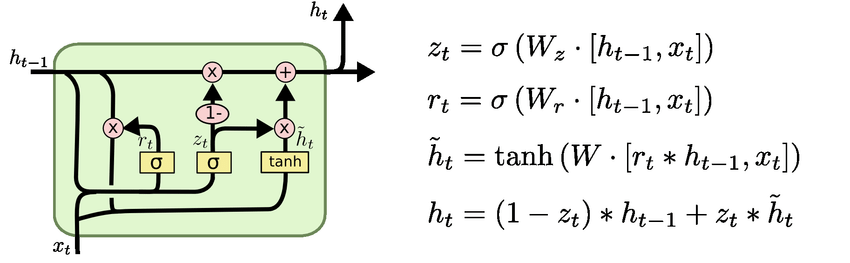

update gate: có nhiệm vụ xác định thông tin trước đó cần chuyển qua trạng thái tiếp theo
$$z_t=\sigma(W_z(x_t)+U_z(h_{t-1})$$ 

kết quả cho ra đi qua hàm sigmoid thu được kết quả từ 0-1. Update gate giúp mô hình ước lượng thông tin trong  hữu ích quá khứ. và bây giờ history: $z_t$ 

reset gate: thiết lập lại quyết định lượng thông tin quá khứ cần thiết cần bỏ qua.

Công thức này giống như là công thức ở cổng update đã nêu trên. Sự khác biệt chỉ là ở trọng lượng và mức sử dụng của cổng này. 
Nội dung nhớ hiện tại:
$$h'_t=tanh(Wx_t+r_t*Uh_{t-1}$$
Qua đó sẽ giúp xác định chính xác thứ sẽ ảnh hưởng tới kết quả cuối cùng
 Bộ nhớ cuối cùng ở bước thời gian hiện tại:
 $$h_t=z_t*h_{t-1}+(1-z_t)*h'_t$$
 qua đó xác định được thông tin cần đưa vào mạng

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Done")
print(model.summary())

In [ ]:
#training
model.fit(train_X,train_y,epochs=2,batch_size=512, validation_data=(val_X, val_y))
print("Done")

# Threshold

Bình thường ở các mô hình phân lớp nhị phân kết quả dự đoán luôn thuộc (0,1) threshold=0.5.

Nếu threshold < 0.5 thì phân lớp là negative, ngược lại thì là positive

Nhưng trong một số trường hợp, giá trị 0.5 này có thể chưa phải là tốt nhất. Trong bài toán này, mục đích của chúng ta tìm ra được càng nhiều câu không chân thành càng tốt, qua đó sẽ giúp giảm nội dung xấu trên quora vậy nên chọn threhold sao cho f1_score là cao nhất

In [ ]:
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))

Ta lựa chọn threshold là 0.28


In [ ]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y = np.where(pred_test_y>0.28,1,0)                                
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("submission.csv", index=False)

Kết quả: Nhìn chung mô hình đạt được độ chính xác f1_score: 65,5%

Để gia tăng hiệu quả mô hình em nghĩ cần tăng độ phủ của các file embedding lên toàn bộ file test và train qua đó sẽ giúp gia tăng độ hiệu quả của mô hình


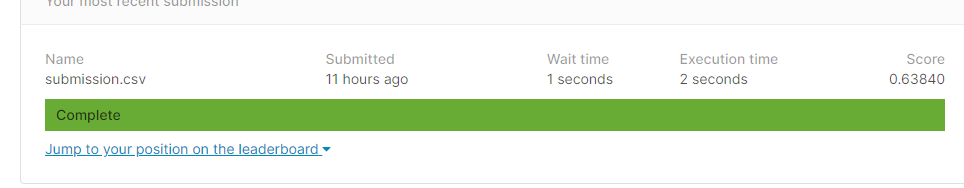